<a href="https://colab.research.google.com/github/moimigueldev/tensorflow-ztm/blob/main/rice-classification/rice_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify 5 types of rice

[Kaggle Dataset](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset)

# import data and helpers

In [1]:
# Download Helper File & Rice Data
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
!wget https://www.dropbox.com/s/sd69bn3a5iq70wk/rice-images.zip?dl=0

--2022-06-04 11:58:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-04 11:58:49 (79.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]

--2022-06-04 11:58:50--  https://www.dropbox.com/s/sd69bn3a5iq70wk/rice-images.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/sd69bn3a5iq70wk/rice-images.zip [fol

In [2]:
# Imports
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
# unzip rice-data
# I preprocessed the data by splitting them into testing and training 
#   directories each at a different percentage to help train faster.
unzip_data('rice-images.zip?dl=0')

In [4]:
# training data at 3%
walk_through_dir('train_3')

There are 5 directories and 1 images in 'train_3'.
There are 0 directories and 450 images in 'train_3/Basmati'.
There are 0 directories and 450 images in 'train_3/Karacadag'.
There are 0 directories and 450 images in 'train_3/Jasmine'.
There are 0 directories and 450 images in 'train_3/Arborio'.
There are 0 directories and 450 images in 'train_3/Ipsala'.


# Data Preprocessing

In [5]:
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32
RANDOM_STATE = 42
LABEL_NAMES = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

In [6]:
train_3_percent = tf.keras.preprocessing.image_dataset_from_directory(
    'train_3',
    label_mode='categorical',
    image_size= IMG_SHAPE,
    batch_size= BATCH_SIZE
)

train_5_percent = tf.keras.preprocessing.image_dataset_from_directory(
    'train_5',
    label_mode='categorical',
    image_size= IMG_SHAPE,
    batch_size= BATCH_SIZE
)

train_80_percent = tf.keras.preprocessing.image_dataset_from_directory(
    'train_80',
    label_mode='categorical',
    image_size= IMG_SHAPE,
    batch_size= BATCH_SIZE
)

test_20_percent = tf.keras.preprocessing.image_dataset_from_directory(
    'test_20',
    label_mode='categorical',
    image_size= IMG_SHAPE,
    batch_size= BATCH_SIZE
)




Found 2250 files belonging to 5 classes.
Found 3750 files belonging to 5 classes.
Found 6000 files belonging to 5 classes.
Found 15000 files belonging to 5 classes.


## Create data augmentation layer 

In [7]:
data_aug_dial = 0.2
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(data_aug_dial),
  tf.keras.layers.RandomZoom(data_aug_dial),
  tf.keras.layers.RandomWidth(data_aug_dial),
  tf.keras.layers.RandomHeight(data_aug_dial),
], name = 'data_augmetation_layer')

# Visualize Data

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

# function to view randoms samples 
def show_random_image():

  random_class = random.choice(LABEL_NAMES)
  target_dir = f'train_80/{random_class}'
  random_image = random.choice(os.listdir(target_dir))
  image_path = f'{target_dir}/{random_image}'
  image = mpimg.imread(image_path)

  plt.figure(figsize=(10, 15))

  # Regular Image
  plt.subplot(1, 2, 1)
  plt.title(f'Regular Image (type: {random_class})')
  plt.axis(False)
  plt.imshow(image)

  # Augmented Image
  augmented_image = data_augmentation(tf.expand_dims(image, axis=0), training=True)
  plt.subplot(1, 2, 2)
  plt.title(f'Augmented Image')
  plt.axis(False)
  plt.imshow(tf.squeeze(augmented_image/255.))
  return image_path


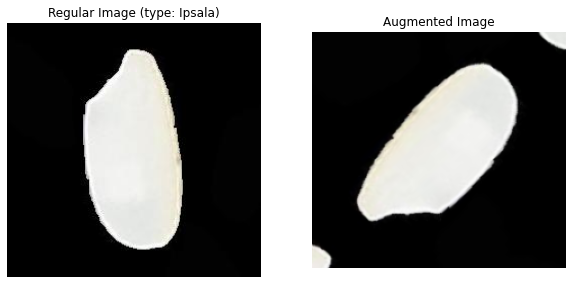

In [9]:
image = show_random_image()

In [10]:
#Set checkpoint path
checkpoint_path = 'model_1_checkpoint_weights/checkpoint.ckpt'

# Create a ModelCheckPoint callback that saves the model's weights only 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=checkpoint_path,
  save_weights=True,
  save_best_only=False,
  save_freq='epoch', # save every epoch
  verbose=1
)

# Model Creation

* The first model will be the base model using transfer learning.  

* Once the feature extraction base model is created, we can use unfreeze some  layers to fine tune.

* We start using small incremented of data (3%) and will increase daeta as the model becomes complex.

* We'll use EfficientNetB0 for now and might use different model based off results

In [ ]:
# Model_1 (Feature Extraction)

input_shape = IMG_SHAPE + (3,)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape= input_shape, name='input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

# Feature extractions
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)


model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

initial_epochs = 5
history_1 = model_1.fit(
    train_3_percent,
    epochs=initial_epochs, 
    steps_per_epoch=len(train_3_percent),
    validation_data=test_20_percent,
    validation_steps=int(.25*len(test_20_percent)),
    callbacks=[checkpoint_callback]
)

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 0.5996 - accuracy: 0.8689
Epoch 1: saving model to model_1_checkpoint_weights/checkpoint.ckpt
INFO:tensorflow:Assets written to: model_1_checkpoint_weights/checkpoint.ckpt/assets
71/71 [==============================] - 66s 736ms/step - loss: 0.5996 - accuracy: 0.8689 - val_loss: 0.2867 - val_accuracy: 0.9485
Epoch 2/5
 1/71 [..............................] - ETA: 28s - loss: 0.1818 - accuracy: 1.0000

In [ ]:
plot_loss_curves(history_1)


In [ ]:
# Evaluate and save full testing set
model_1_results = model_1.evaluate(test_20_percent)

* Model_1 right off the bat has a high accuracy score without any fine tuning on only 3 percent of the dataset. On the full validation (3000 samples) the model was able to retain it's high accuracy percentage of 97%

* The loss & accuracy score show the model could have had better results if we traned it for more epochs

Let's try some fine tuning

## Create model_2 off of checkpointed model_1 for fine tuning

In [ ]:
model_2 = tf.keras.Model(inputs, outputs)
model_2.load_weights(checkpoint_path)
model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])




## Unfreeze layers (10)

* before fittin our model we have to unfreze some of the bottom layers to be able to train them on our custom data 

* We will unfreeze the last 10

* When fine tuning, we'll change the learning rate to a much lower value since we don't want to change the base weights too much.

In [ ]:
# Right now there are no trainable variables
model_2.layers[2].trainable_variables

In [ ]:
# Unfreeze layers

base_model.trainable = True

# Freeze all layers except fo the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile model
model_2.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)


In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

Now we can see that all layers are kept frozen except for the last 10

## Fit model_2

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_2 = model_2.fit(
    train_3_percent,
    epochs = fine_tune_epochs,
    steps_per_epoch=len(train_3_percent),
    validation_data=test_20_percent,
    validation_steps = int(.25 * len(test_20_percent)),
    initial_epoch= history_1.epoch[-1]
)



In [ ]:
# Evaluate on the full test dataset
model_2_results = model_2.evaluate(test_20_percent)
model_2_results

* Looks like our initial fine tuning model did get significant increase on validation data from `95%` to `97%`

* Fine tuning works best on a larger set of data. Right now we only used 3% of training data so lets up it to 80% and see how it performs


### model_2 training on 80% of data



In [ ]:
# reset model_2 to model_1 weights
model_2.load_weights(checkpoint_path)

# Recompile model
model_2.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)



In [ ]:
# fit model_2 on 5%of data
fine_tune_epochs = initial_epochs + 5

history_3_80_percent = model_2.fit(
    train_80_percent,
    epochs = fine_tune_epochs,
    steps_per_epoch=len(train_80_percent),
    validation_data=test_20_percent,
    validation_steps = int(.25 * len(test_20_percent)),
    initial_epoch= history_1.epoch[-1]
)



In [ ]:
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History Objects
  """

  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']
  
  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']
  
  total_val_acc = val_acc + new_history.history['val_accuracy'] 
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plot for accuracy
  plt.figure(figsize=(8,8))

  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Trainig Acc')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and validation accuracy')

  # Make plot for loss
  plt.figure(figsize=(8,8))

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Trainig Loss')
  plt.plot(total_val_loss, label='Validation loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and validation loss')

In [ ]:
compare_histories(history_1, history_3_80_percent)

In [ ]:
history_3_results_80_percent = model_2.evaluate(test_20_percent)
history_3_results_80_percent

In [ ]:
# Compare results
history_3_results_80_percent[1], model_2_results[1],  model_1_results[1]

 Model 3 was the best model with 97% accuracy